In [ ]:
!pip install scanpy
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
from scipy.stats import pearsonr
#
#more 10x datasets 
#https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/


#switch to keras for custom ae
#https://blog.keras.io/building-autoencoders-in-keras.html
#merging nerual networks
#https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



     |████████████████████████████████| 2.0 MB 4.0 MB/s 
     |████████████████████████████████| 91 kB 5.2 MB/s 
     |████████████████████████████████| 86 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 34.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=e36ccc64399ad782b778df767fa5fbc9f4353f2594d33afd9372741623d90472
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1e6fd7da6cc2a0e4674d771010f7d94bf5d3f1665f4a212b5f0e511416230cc6
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=555ff10a9073a27fa5b5a68746957d5831e2afc89fbf5879c52a7ed23b5d386a
  Stored in directory: /root/.cache/pi

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#make a shortcut to emily's shared drive folder in your drive so you can access the data at
import os
os.listdir('/content/drive/My Drive/methyl_impute')

Mounted at /content/drive


['Peek_data.ipynb',
 'Project Proposal Brainstorming.gdoc',
 'adult_cortex_CG-CH_OLDCOPY.h5ad',
 'adult_cortex_CG_CH.h5ad',
 'tf_multiclass_prediction.ipynb',
 'classifier_results.gslides',
 'Presentation.gslides',
 'VAE_impute (variational).ipynb',
 'ch_isImputed.parq',
 'cg_isImputed.parq',
 'PredictionModel.ipynb',
 'Project_Report.gdoc',
 'VAE_impute (vanilla) (custom dropout+loss).ipynb',
 'vanilla tuning',
 'VAE_impute (vanilla+tuned).ipynb',
 'VAE_impute (vanilla) (custom dropout).ipynb',
 'VAE_impute (variational+tuned).ipynb',
 'VAE_impute (variational+loss).ipynb']

In [ ]:
adata=sc.read_h5ad('/content/drive/My Drive/methyl_impute/adult_cortex_CG_CH.h5ad')
adata

AnnData object with n_obs × n_vars = 11945 × 44772
    obs: 'sample', 'L1', 'L2', 'L3', 'true_batch', 'age', 'age_groups', 'leiden'
    var: 'batch'
    uns: 'L2_colors', 'L3_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
#collect top marker genes

sc.tl.rank_genes_groups(adata, 'L3',n_genes=20)
# sc.pl.rank_genes_groups(adata, sharey=False)
markers=[]
for i in range(27):
    for j in range(20):
        if adata.uns['rank_genes_groups']['names'][j][i] not in markers:
            markers.append(adata.uns['rank_genes_groups']['names'][j][i])
"""adata2=adata[:,markers]
sc.pp.scale(adata2)
sc.pl.heatmap(adata2, markers, groupby='L3',vmax=1,vmin=-1)"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()

"adata2=adata[:,markers]\nsc.pp.scale(adata2)\nsc.pl.heatmap(adata2, markers, groupby='L3',vmax=1,vmin=-1)"

In [ ]:
adata=adata[:,markers]
adata

View of AnnData object with n_obs × n_vars = 11945 × 351
    obs: 'sample', 'L1', 'L2', 'L3', 'true_batch', 'age', 'age_groups', 'leiden'
    var: 'batch'
    uns: 'L2_colors', 'L3_colors', 'leiden', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
#data matrix, X
X=np.array(adata.X)
print(X.shape)

(11945, 351)


In [ ]:
print(X.shape[1])

351


In [370]:
# lr=[0.001,0.01,0.1]
# batchsize=[128,256,512]
# nlatent=[16,32,64]
class VAE:
  def __init__(self, input_shape,batch_size=256,optimizer=keras.optimizers.Adam(learning_rate=.001),epochs=10,
               recon_loss_function=tf.keras.losses.MeanSquaredError(),callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)):
    # self.mu=layers.Dense(32,name='mu')
    # self.sigma=layers.Dense(32,name='sigma')
    self.mu = None
    self.sigma = None

    self.input_shape=input_shape
    self.batch_size=batch_size
    self.n_epochs=epochs
    self.optimizer=optimizer
    self.recon_loss_function=recon_loss_function
    self.callback=callback
    # self.model=self.generate_model_architecture()
    # self.model.compile(optimizer=optimizer,loss=self.vae_loss)
    self.encoder=self.generate_encoder()
    self.encoder.compile(optimizer=optimizer,loss=self.vae_loss)
    self.sampler=self.perform_sampling()
    # self.sampler.compile(optimizer=optimizer,loss=self.vae_loss)
    self.decoder=self.generate_decoder()
    self.decoder.compile(optimizer=optimizer,loss=self.vae_loss)
    self.kappa=1

  def vae_loss(self, y_true, y_pred):
    recon = self.recon_loss_function(y_true, y_pred)
    kl = K.mean(0.5*K.sum(K.exp(self.sigma) + K.square(self.mu) - 1. - self.sigma, axis=1))
    # print(recon,self.kappa*kl)
    return recon,self.kappa*kl/200
    # return 200*recon + self.kappa*kl

  def sample_z(self, args):
    vae_mu, vae_sigma = args
    eps = K.random_normal(shape=(K.shape(vae_mu)[0], K.shape(vae_mu)[1]), mean=0., stddev=1., seed=42)
    return vae_mu + K.exp(vae_sigma/2)*eps

  def kl_loss(self):
    return K.mean(0.5*K.sum(K.exp(self.sigma) + K.square(self.mu) - 1. - self.sigma, axis=1))

  def generate_encoder(self):
    mC_input=keras.Input(shape=(self.input_shape,),name='mC_input')
    dense1=layers.Dense(128,activation='relu', name='dense1')(mC_input)
    dense2=layers.Dense(64,activation='relu', name='dense2')(dense1)
    vae_mu=layers.Dense(32,activation='linear')(dense2)
    vae_sigma=layers.Dense(32,activation='linear')(dense2)

    return Model(mC_input, (vae_mu, vae_sigma), name='encoder')

  def perform_sampling(self):
    vae_mu = keras.Input(shape=(32,))
    vae_sigma = keras.Input(shape=(32,))
    out=layers.Lambda(self.sample_z)([vae_mu, vae_sigma])
    return Model([vae_mu, vae_sigma], out, name='sampler')

  def generate_decoder(self):
    input_latent = keras.Input(shape=(32,))
    out_pred=layers.Dense(self.input_shape,activation='linear',name='out_pred')(input_latent)
    return Model(input_latent, out_pred, name='decoder')

  """def generate_model_architecture(self):
    mC_input=keras.Input(shape=(self.input_shape,),name='mC_input')
    dense1=layers.Dense(128,activation='relu', name='dense1')(mC_input)
    dense2=layers.Dense(64,activation='relu', name='dense2')(dense1)
    self.mu=self.mu(dense2)
    self.sigma=self.sigma(dense2)
    latent=layers.Lambda(self.sample_z, output_shape=(32,), name='latent')([self.mu, self.sigma])
    # latent=layers.Dense(32,activation='relu', name='latent')(dense2)
    out_pred=layers.Dense(self.input_shape,activation='linear',name='out_pred')(latent)

    return Model(mC_input,out_pred)"""


  def train_vae(self,train_dataset,test_dataset):
    train_acc_metric = keras.metrics.MeanSquaredError()
    test_acc_metric = keras.metrics.MeanSquaredError()
    total_loss=[]
    kl_loss=[]
    recon_loss=[]
    v=[]
    epochs = self.n_epochs
    for epoch in range(epochs):

        print("\nStart of epoch %d" % (epoch,))
        print(self.kappa)
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape:
                self.mu, self.sigma = self.encoder(x_batch_train, training=True)
                latent = self.sampler([self.mu, self.sigma])
                logits=self.decoder(latent, training=True)
                # logits = self.model(x_batch_train, training=True)
                kl,recon = self.vae_loss(x_batch_train, logits)
                loss_value=kl+recon
                # print(loss_value)
            # print(kl,recon,loss_value)
            encoder_grads = encoder_tape.gradient(loss_value, self.encoder.trainable_weights)
            decoder_grads = decoder_tape.gradient(loss_value, self.decoder.trainable_weights)
            self.optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
            self.optimizer.apply_gradients(zip(decoder_grads, self.decoder.trainable_weights))
            # grads = tape.gradient(loss_value, self.model.trainable_weights)
            # self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

            # Update training metric.
            train_acc_metric.update_state(x_batch_train, logits)

            # Log every 31 batches.
            if step % 31 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )

                #print("Seen so far: %d samples" % ((step + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        # print("Reconstruction Training acc over epoch: %.4f" % (float(train_acc),))
        # print("KL Divergence: %.10f" % (float(self.kl_loss())))
        kl_loss.append(kl)
        recon_loss.append(recon)
        total_loss.append(loss_value)

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_test in test_dataset:
            self.mu, self.sigma = self.encoder(x_batch_test, training=False)
            latent = self.sampler([self.mu, self.sigma])
            test_logits = self.decoder(latent, training=False)
            # test_logits = self.model(x_batch_test, training=False)
            # Update val metrics
            test_acc_metric.update_state(x_batch_test, test_logits)
        test_acc = test_acc_metric.result()
        test_acc_metric.reset_states()
        # print("Validation acc: %.4f" % (float(test_acc),))
        v.append(float(test_acc))
        #print("Time taken: %.2fs" % (time.time() - start_time))

        if self.kappa < 0.95:
            self.kappa += 0.25
    return kl_loss,recon_loss,total_loss,v


  def predict(self,X):
    self.mu, self.sigma = self.encoder.predict(X)
    latent = self.sampler([self.mu, self.sigma])
    return self.decoder.predict(latent)

  def model_summary(self):
    print(self.model.summary())

  def visualize_model(self):
    #dunno how to make this show from the function lol
    keras.utils.plot_model(self.model, show_shapes=True, show_layer_names=True)

  def correlation_accuracy(self, real_data):
    reconstructed_data = self.predict(real_data)
    corrs = 0
    for i in range(len(reconstructed_data)):
        corrs += pearsonr(reconstructed_data[i], real_data[i])[0]

    print(corrs/len(reconstructed_data))

  def mse_error(self, real_data):
    reconstructed_data = self.predict(real_data)
    mse = 0
    for i in range(len(reconstructed_data)):
        mse += mean_squared_error(reconstructed_data[i], real_data[i])

    print(mse/len(reconstructed_data))




In [371]:
# X_train, X_test = train_test_split(X, test_size=0.33, random_state=42,shuffle=True)
X_train, X_test = train_test_split(np.array(adata.X), test_size=0.33, random_state=42,shuffle=True)

In [372]:
vae=VAE(X_train.shape[1])

In [373]:
# batch_size=256
batch_size=256

train_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(batch_size)

In [374]:
len(X_train)/batch_size

31.26171875

In [375]:
#16,32,64
# c=32
# c1=16
# c2=64

In [376]:
# c1=0.001
# c=0.01
# c2=0.1

In [377]:
#c1=256
#c2=512

In [378]:
a1,b1,c1,v1=vae.train_vae(train_dataset,test_dataset)


Start of epoch 0
1
Training loss (for one batch) at step 0: 0.3743
Training loss (for one batch) at step 31: 0.1228

Start of epoch 1
1
Training loss (for one batch) at step 0: 0.1184
Training loss (for one batch) at step 31: 0.0701

Start of epoch 2
1
Training loss (for one batch) at step 0: 0.0698
Training loss (for one batch) at step 31: 0.0521

Start of epoch 3
1
Training loss (for one batch) at step 0: 0.0511
Training loss (for one batch) at step 31: 0.0378

Start of epoch 4
1
Training loss (for one batch) at step 0: 0.0403
Training loss (for one batch) at step 31: 0.0331

Start of epoch 5
1
Training loss (for one batch) at step 0: 0.0384
Training loss (for one batch) at step 31: 0.0332

Start of epoch 6
1
Training loss (for one batch) at step 0: 0.0331
Training loss (for one batch) at step 31: 0.0320

Start of epoch 7
1
Training loss (for one batch) at step 0: 0.0328
Training loss (for one batch) at step 31: 0.0306

Start of epoch 8
1
Training loss (for one batch) at step 0: 0.0

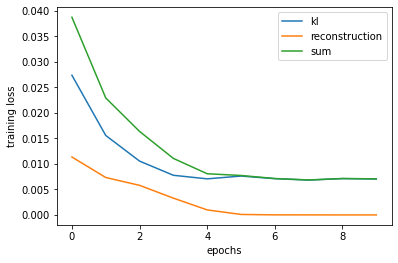

In [379]:
import matplotlib.pyplot as plt
plt.plot(a,label='kl')
# plt.yscale('log')
plt.plot(b,label='reconstruction')
plt.plot(c,label='sum')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.savefig('drive/My Drive/methyl_impute/VAE_tune/loss_tuned.png')
plt.legend()

In [380]:
c

[<tf.Tensor: shape=(), dtype=float32, numpy=0.038723983>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.022924326>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.016367633>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.011084686>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008078629>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0077397544>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.007144026>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0068629826>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0071474425>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0070740003>]

In [381]:
c1

[<tf.Tensor: shape=(), dtype=float32, numpy=0.12278095>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.070071906>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.052131984>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03782294>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.033053983>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.033218402>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.031968877>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03060445>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03131914>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.025640864>]

In [382]:
c2

[<tf.Tensor: shape=(), dtype=float32, numpy=0.040164776>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.02114865>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.014397226>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0084674135>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.007526367>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0069351476>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008009836>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0072413506>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.007038365>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0076564504>]

Text(0, 0.5, 'training loss total')

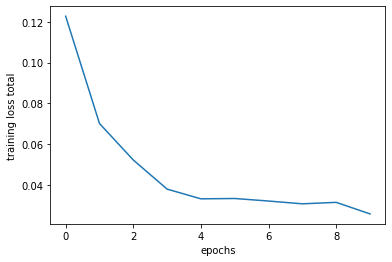

In [383]:
plt.plot(c1)
plt.xlabel('epochs')
plt.ylabel('training loss total')
# plt.savefig('drive/My Drive/methyl_impute/VAE_tune/lr_curve.png')

In [384]:
v1

[0.07351943105459213,
 0.043205615133047104,
 0.03196299821138382,
 0.026269232854247093,
 0.02287239208817482,
 0.018491877242922783,
 0.02025478519499302,
 0.01588219776749611,
 0.01562614180147648,
 0.01613932102918625]

Text(0, 0.5, 'training loss total')

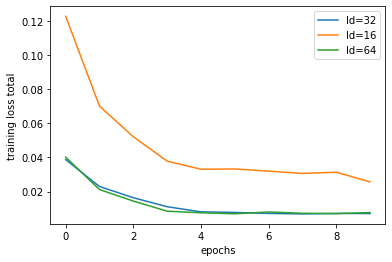

In [385]:
plt.plot(c,label='ld=32')
plt.plot(c1,label='ld=16')
plt.plot(c2,label='ld=64')
# plt.yscale('log')
plt.xlabel('epochs')
plt.legend()
plt.ylabel('training loss total')
# plt.savefig('drive/My Drive/methyl_impute/VAE_tune/lr_curve.png')

Text(0, 0.5, 'validation loss total')

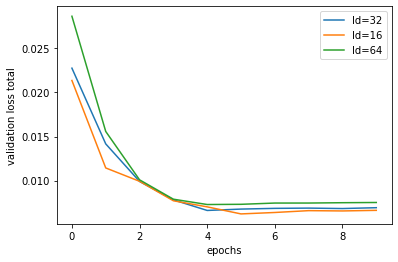

In [356]:
plt.plot(v,label='ld=32')
plt.plot(v1,label='ld=16')
plt.plot(v2,label='ld=64')
# plt.yscale('log')
plt.xlabel('epochs')
plt.legend()
plt.ylabel('validation loss total')
# plt.savefig('drive/My Drive/methyl_impute/VAE_tune/lr_curve.png')

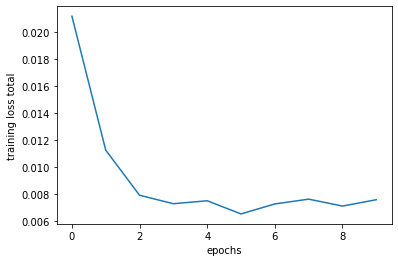

In [ ]:
plt.plot(c)
plt.xlabel('epochs')
plt.ylabel('training loss total')
plt.savefig('drive/My Drive/methyl_impute/VAE_tune/tl_vae_0.01_32_128.png')

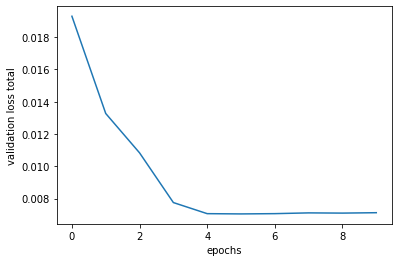

In [ ]:
plt.plot(v)
plt.xlabel('epochs')
plt.ylabel('validation loss total')
plt.savefig('drive/My Drive/methyl_impute/VAE_tune/vl_vae_0.01_32.png')

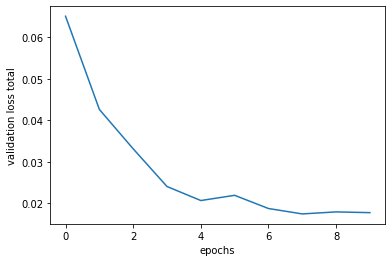

In [ ]:
plt.plot(v)
plt.xlabel('epochs')
plt.ylabel('validation loss total')
plt.savefig('drive/My Drive/methyl_impute/VAE_tune/vl_vae_0.001_32.png')

In [ ]:
# vae.correlation_accuracy(X_train)
vae.correlation_accuracy(X_test)
# vae.mse_error(X_train)
vae.mse_error(X_test)

In [ ]:
vae.predict(X_train)

array([[0.81390166, 0.7571076 , 0.83713293, ..., 0.84207594, 0.6263951 ,
        0.5171102 ],
       [0.34751552, 0.31697428, 0.3881275 , ..., 0.3748241 , 0.30883527,
        0.27387017],
       [0.93105495, 0.77815723, 0.9492974 , ..., 0.95477927, 0.603935  ,
        0.56040776],
       ...,
       [0.4949968 , 0.42560875, 0.52743685, ..., 0.4901822 , 0.36123234,
        0.36325553],
       [0.40315598, 0.3751915 , 0.41595042, ..., 0.4546417 , 0.34973374,
        0.319578  ],
       [0.68611366, 0.60800904, 0.75253904, ..., 0.66794395, 0.5282955 ,
        0.5137501 ]], dtype=float32)